# Reaction Diffusion system

So right off the bat I'm going to recommend reading [Karl Sim's explanation](https://www.karlsims.com/rd.html) of how the following patterns arise in this system; it's filled with many fantastic diagrams and I could not have done that better myself. So here I'm going to build upon his explanation and focus more on dissecting how the code is applying these abstract ideas.

If you saw the [chaos design](https://bfbarry.github.io/automadrawn/Chaos.html), we talked about *dynamical systems*, which can be described by differential equations. The reaction diffusion system, using the Gray-Scott model, is also a dynamical system - but instead of ordinary differential equations (ODEs), it uses partial differential equations (PDEs). So... what's the difference? In ODEs, when we solve the differential equation, we get an equation of the form of $x(t) = \ ...$ It depends on a single variable, t (time). In PDEs, we crank the complexity up a bit, and are solving for an equation dependent on multiple variables besides time, with solutions that can look like $x(t, m)$, where $m$ for instance could be the mass of some material involved in the system. In our case, we have variables $a$ and $b$, which are concentrations of two different interacting chemicals (they *react* with each other, and then *diffuse* across a surface). So the underlying equation for the dynamics is going to be of the form $f(t,a)$ and $f(t,b)$. These equations also use the constants $F$ & $K$ (the rates of 'feed' and 'kill'), $D_a$ & $D_b$ (the rates of diffusion), and the Laplacian operator $\nabla^2$ which pretty much performs the diffusion of each chemical.

$$
\frac{\partial a}{\partial t} = \underbrace{D_a \boldsymbol\nabla^2 a}_{\substack{\text{diffusion of }a}} - \underbrace{ab^2}_{\text{probability of reaction}} + \underbrace{F(1-a)}_{\substack{\text{amount of feed in}}}
$$$$
\frac{\partial b}{\partial t} = \underbrace{D_b \boldsymbol\nabla^2 b}_{\substack{\text{diffusion of }b}} + \underbrace{ab^2}_{\text{probability of reaction}} - \underbrace{(F+K)b}_{\substack{\text{amount of feed out}}}
$$

The two equations are the PDEs, where the left hand side are partial derivatives describing the rates of change of the system with respect to the two chemicals `a` and `b`. These equations can't be solved analytically (i.e., with pen and pencil), so we have to solve them numerically, which you can think of as brute force approach. This is done using the Euler method, which discretizes the time steps, and iteratively finds the state of the system through time. So instead of a system with the partial derivatives above, we multiply both sides of each equation by the $\partial t$ - and since we are using a discrete time step, we rewrite the notation to be $\Delta t$. Next, the $\partial a$ or $\partial b$ will become $\Delta a$ or $\Delta b$ as well. Since this $\Delta$ just means the difference of values between time steps, this can be split up into $a_{t+1} - a$ and the same for $b$. Adding $a$ and $b$ to each side, we get our desired form, where we can see that the value of a chemical at the next time step (e.g., $a_{t+1}$) is dependent on the previous values (e.g., $a$), transformed by some nonlinear algebra, on the right hand sides. This process is somewhat similar to how we iterate over states in the [chaos design](https://bfbarry.github.io/automadrawn/Chaos.html).

$$
a_{t+1} = a + ({D_a \boldsymbol\nabla^2 a} - {ab^2} + {F(1-a)}){\Delta t}
$$$$
b_{t+1} = b + ({D_b \boldsymbol\nabla^2 b} + {ab^2} - (F+K)b){\Delta t}
$$

This process, which is the bulk of the simulation, takes place in the `for` loop of the `evolve()` method. Note that we use $\Delta t = 1$ for simplicity.

I have been leaving out the final crucial part of these equations, the Laplacian, which in the Euler method becomes a discrete Laplace operator, since we are carrying out the process on a grid. In our object, `self.a` and `self.b` are going to be 2d matrices where each value represents the concentration of the respective chemical at that point on the 2d grid. The Laplacian is pretty much just a big sparse 2d matrix (like the one below), that upon computing the dot product with a vectorized $a$ or $b$ determines how much each chemical should diffuse across the grid, at each cell, based on the values of itself and its 4 neighbors. If you are familiar with signal processing or computer vision, this is a bit like convolution. 

<img src='./img/5_5laplacian.png' style="display: block; margin-left: auto; margin-right: auto;"></img>

This is another case of the fascinating relationship between mathematical models and *real* phenomena - the reaction diffusion equations can be used to model all sorts of patterns: those on animal fur (Alan Turing was [the first to discover this](https://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf)), [the folds of our brains](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000749), and nonequilibrium chemical reactions (like the Belousov-Zhabotinsky pictured below), which is what the Gray-Scott equations model. Notice however that these all demonstrate the same phenomenon - they involve interactions of *things* over *time* – which is why PDEs in general are perhaps the most desired modeling tool in physics and applied mathematics. Going deeper, what is most mind-boggling about the behavior of these systems is that *large scale* patterns are emerging from interactions of huge numbers of particles at *microscopic* scales!

<img src='./img/bz.gif' style="display: block; margin-left: auto; margin-right: auto;"></img>

Just like with the chaos and cellular automata designs, the realm of potential patterns with this system are incredible. Play around with different values of `Da`, `Db`, `F` and `K`. I created a dictionary of some of the most typical patterns. You can explore the vast range of possibilities on [Robert Munafo's page](http://mrob.com/pub/comp/xmorphia/).

Warning: it may take a long time to run. For a grid size of 256 and 32000 time steps - good enough to get a view of the design - it took me 6 minutes. For some reason smaller grid sizes don't really render any patterns properly, possibly an artifact of floating point precision.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from IPython.display import clear_output

In [28]:
patterns = {'bacteria':  {'Da':0.14, 'Db':0.06, 'F':0.035, 'K': 0.065},
            'coral':     {'Da':0.16, 'Db':0.08, 'F':0.060, 'K': 0.062},
            'spiral':    {'Da':0.12, 'Db':0.08, 'F':0.020, 'K': 0.050},
            'zebrafish': {'Da':0.16, 'Db':0.08, 'F':0.035, 'K': 0.060}}

class ReactionDiffusion:
    def __init__(self, N):
        """
        sets up initial conditions
        N: width/height of grid
        """
        self.N = N
        self.a = np.ones((N, N), dtype=np.float128)
        self.b = np.zeros((N, N), dtype=np.float128)
        
        N, N2, r = self.N, np.int(self.N/2), 16
        
        self.a += 0.02 * np.random.random((N,N)) # random noise to grid for initial conditions
        self.b += 0.02 * np.random.random((N,N))
        
        self.a[N2 - r : N2 + r, N2 - r : N2 + r] = 0.50 # initialize concentrations of chemicals at the center
        self.b[N2 - r : N2 + r, N2 - r : N2 + r] = 0.25 # ^
    
    def laplacian(self):
        """
        Constructs a sparse matrix that applies the 5-point discretization across neighbors
        i.e., finite difference approximations to derivatives at grid points
        """
        N = self.N
        e = np.ones(N**2)
        e2 = ([1] * (N-1) + [0]) * N
        e3 = ([0] + [1] * (N-1)) * N
        data = [-4*e, e2, e3, e, e] # numbers to store in diagonals
        diag_loc = [0, -1, 1, -N, N] # sets which diagonals of the matrix to fill out
        L_matrix = spdiags(data, diag_loc, N**2, N**2) # creating a sparse matrix of size N^2 x N^2
        return L_matrix
    
    def evolve(self, Nt, Da, Db, F, K, cmap=plt.cm.RdBu, animate=False):
        """
        solves the PDE using the discretized Euler method
        if animate=True, animates the RD process [very slowly, since computations are slow]"""
        L = self.laplacian()
        
        N = self.N
        a = self.a.flatten() # reshapes to be right size for dot product with L
        b = self.b.flatten() 
        plt.figure(figsize=(10, 10))
        for i in range(Nt): # Euler method iteration
            abb = a*b*b
            a += (Da*L.dot(a) - abb + F*(1-a))
            b += (Db*L.dot(b) + abb - (F+K)*b)
            if animate:
                self.plot_state()
                clear_output(wait=True)
                plt.show()
        
        self.a = a
        self.b = b
        self.plot_state(cmap)
        
    def plot_state(self, cmap):
        a = self.a
        N = self.N
        
        plt.imshow(a.reshape((N,N)),cmap=cmap) #only need to plot one of the chemicals since it is dependent on the other
        plt.axis('off')     

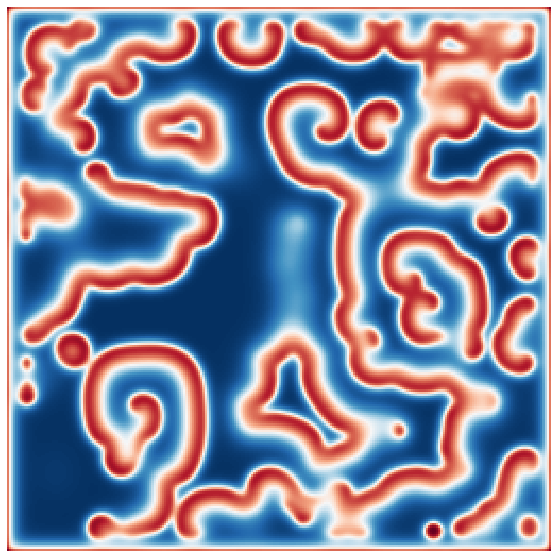

In [25]:
rd = ReactionDiffusion(256)
rd.evolve(Nt=32000, **patterns['spiral'])

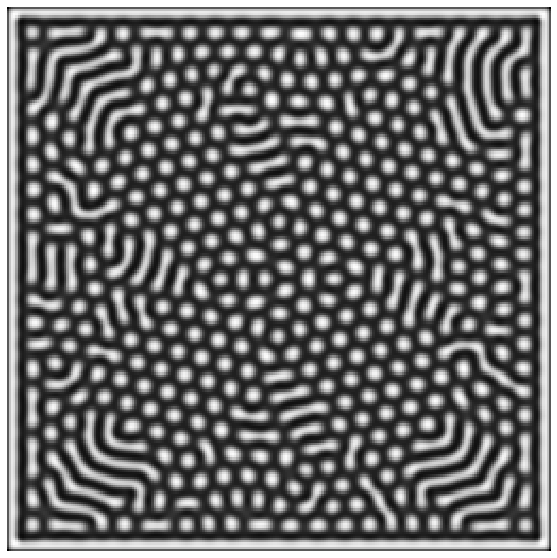

In [40]:
rd = ReactionDiffusion(256)
rd.evolve(Nt=32000, **{'Da':0.14, 'Db':0.06, 'F':0.0660, 'K': 0.0610}, cmap=plt.cm.gray)

# Acknowledgments

- [Karl sims](https://www.karlsims.com/rd.html)
- [BZ reaction gif](https://i.gifer.com/AZUJ.gif)
- Big thanks to [Rajesh Singh's blog post](https://rajeshrinet.github.io/blog/2016/gray-scott/) on simulating the Gray-Scott model, from which most of the code here comes from. 

# Further reading
- https://ipython-books.github.io/124-simulating-a-partial-differential-equation-reaction-diffusion-systems-and-turing-patterns/
- [Discrete Laplace Operator](https://www.wikiwand.com/en/Discrete_Laplace_operator)